# Introduction
(VAE) https://arxiv.org/abs/1312.6114
Variational Autoencoder

From the abstract:

"We introduce a stochastic variational inference and learning algorithm that
scales to large datasets and, under some mild differentiability conditions,
even works in the intractable case. Our contributions is two-fold. First, we
show that a reparameterization of the variational lower bound yields a lower
bound estimator that can be straightforwardly optimized using standard
stochastic gradient methods. Second, we show that for i.i.d. datasets with
continuous latent variables per datapoint, posterior inference can be made
especially efficient by fitting an approximate inference model (also called a
recognition model) to the intractable posterior using the proposed lower bound
estimator."

Basically VAEs encode an input into a given dimension z, reparametrize that z
using it's mean and std, and then reconstruct the image from reparametrized z.
This lets us tractably model latent representations that we may not be
explicitly aware of that are in the data. For a simple example of what this may
look like, read up on "Karl Pearson's Crabs." The basic idea was that a
scientist collected data on a population of crabs, noticed that the distribution
was non-normal, and Pearson postulated it was because there were likely more
than one population of crabs studied. This would've been a latent variable,
since the data colllector did not initially know or perhaps even suspect this.
# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image 


import numpy as np
from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
batch_size = 128
num_epoch = 100

lr = 1e-4 # leanring rate of Encoder and Decoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])
    
# MNIST datasets downloading……
mnist = datasets.MNIST(
    root = '../../data/mnist/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = mnist, batch_size = batch_size, shuffle = True
)

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw




Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw
Processing...


/home/liuchang/.conda/envs/torch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
def to_gray_img(x):
    out = 0.5*(x+1)
    out = out.clamp(0,1) # force therandom distribution of x into [min, max]
    out = out.view(-1, 1, 28, 28) # view a multi-row Tensor as one row
    return out

# Model Definitions
## Encoder
Input of Encoder is an image, output is encoded
    vector representation of that image.
    
As to MLP encoder for VAE. Input is an image,
outputs are the mean, std of the latent variable z pre-reparametrization

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.En = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
        )
        self.mu = nn.Linear(256, 8)
        self.log_var = nn.Linear(256,8)
    
    def forward(self, x):
        x = self.En(x)
        mu, log_var = self.mu(x), self.log_var(x)
        return mu, log_var

## Decoder
Input is an encoded vector representation, output is reconstructed image.

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.De = nn.Sequential(
            nn.Linear(8, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 784),
        )
    
    def forward(self, x):
        x = self.De(x)
        return x

## Variational AutoEncoder
VAE super class to reconstruct an image. Contains reparametrization
    method for latent variable z

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # self.__dict__.update(locals())
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)
        return out_img, mu, log_var
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick: z = mean + std*epsilon,
        where epsilon ~ N(0, 1).
        """
        epsilon = torch.randn(mu.shape).to(device)
        z = mu + epsilon * torch.exp(log_var/2).to(device) # 2 for convert var to std
        return z
    

#  Traning Phase
## Model & Opitmizer

In [8]:
VAE = VAE()
AE = VAE.to(device)

In [9]:

optimizer = torch.optim.Adam(params = [p for p in AE.parameters()
                                      if p.requires_grad],
                             lr = lr
                            )

## Trainning Start!

### WTF is KL divergence loss?
The KL divergence tells us how well the probability distribution $Q$ approximates the probability distribution P by calculating the cross-entropy minus the entropy. Intuitively, you can think of that as the statistical measure of how one distribution differs from another.

In VAE, let X be the data we want to model, z be latent variable, $P(X)$ be the probability distribution of data, $P(z)$ be the probability distribution of the latent variable and $P(X|z)$ be the distribution of generating data given latent variable

In the case of variational autoencoders, our objective is to infer $P(z)$ from $P(z|X)$. $P(z|X)$ is the probability distribution that projects our data into latent space. But since we do not have the distribution $P(z|X)$, we estimate it using its simpler estimation $Q$.

Now while training our VAE, the encoder should try to learn the simpler distribution $Q(z|X)$ such that it is as close as possible to the actual distribution $P(z|X)$. This is where we use KL divergence as a measure of a difference between two probability distributions. The VAE objective function thus includes this KL divergence term that needs to be minimized.
$$D_{KL}[Q(z|X)||P(z|X)]=E[logQ(z|X)−logP(z|X)]$$

In [10]:
def KL_Divergence(mu, log_var):
    """ Compute Kullback-Leibler divergence """
    return torch.sum(0.5 * (mu ** 2 + torch.exp(log_var) - log_var -1))

  0%|          | 0/100 [00:00<?, ?it/s]

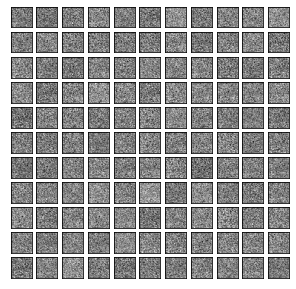

Epoch[0/100],recon_loss:22987.660156, kl_loss:2496.699219


  1%|          | 1/100 [01:07<1:51:00, 67.28s/it]

Epoch[1/100],recon_loss:15949.181641, kl_loss:2178.590332


  2%|▏         | 2/100 [01:45<1:35:26, 58.43s/it]

Epoch[2/100],recon_loss:15073.962891, kl_loss:2069.580811


  3%|▎         | 3/100 [02:40<1:33:08, 57.61s/it]

Epoch[3/100],recon_loss:14298.786133, kl_loss:2046.227295


  4%|▍         | 4/100 [03:20<1:23:22, 52.11s/it]

Epoch[4/100],recon_loss:14587.716797, kl_loss:2046.229248


  5%|▌         | 5/100 [04:15<1:24:05, 53.11s/it]

Epoch[5/100],recon_loss:13543.646484, kl_loss:1988.625977


  6%|▌         | 6/100 [04:56<1:17:42, 49.60s/it]

Epoch[6/100],recon_loss:13500.958984, kl_loss:1994.847656


  7%|▋         | 7/100 [05:52<1:19:36, 51.36s/it]

Epoch[7/100],recon_loss:13055.706055, kl_loss:1980.190552


  8%|▊         | 8/100 [06:32<1:13:40, 48.05s/it]

Epoch[8/100],recon_loss:12601.833008, kl_loss:1917.648315


  9%|▉         | 9/100 [07:22<1:13:45, 48.63s/it]

Epoch[9/100],recon_loss:11466.416016, kl_loss:1934.157227


 10%|█         | 10/100 [07:57<1:06:46, 44.51s/it]

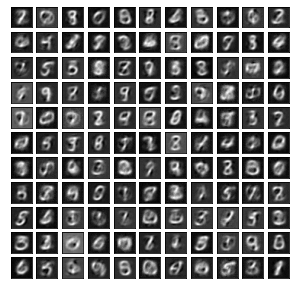

Epoch[10/100],recon_loss:12537.104492, kl_loss:1909.192139


 11%|█         | 11/100 [09:08<1:17:44, 52.41s/it]

Epoch[11/100],recon_loss:12578.122070, kl_loss:1906.555420


 12%|█▏        | 12/100 [09:48<1:11:30, 48.75s/it]

Epoch[12/100],recon_loss:12701.631836, kl_loss:1891.877930


 13%|█▎        | 13/100 [10:34<1:09:20, 47.82s/it]

Epoch[13/100],recon_loss:12599.300781, kl_loss:1886.273926


 14%|█▍        | 14/100 [11:15<1:05:44, 45.87s/it]

Epoch[14/100],recon_loss:12674.224609, kl_loss:1890.985962


 15%|█▌        | 15/100 [12:01<1:04:59, 45.88s/it]

Epoch[15/100],recon_loss:11969.583984, kl_loss:1878.263428


 16%|█▌        | 16/100 [12:39<1:01:01, 43.59s/it]

Epoch[16/100],recon_loss:11978.638672, kl_loss:1929.135742


 17%|█▋        | 17/100 [13:20<59:04, 42.71s/it]  

Epoch[17/100],recon_loss:11495.701172, kl_loss:1895.867676


 18%|█▊        | 18/100 [14:02<57:59, 42.43s/it]

Epoch[18/100],recon_loss:11555.625000, kl_loss:1868.779175


 19%|█▉        | 19/100 [14:46<57:56, 42.92s/it]

Epoch[19/100],recon_loss:12318.788086, kl_loss:1906.412598


 20%|██        | 20/100 [15:33<58:48, 44.11s/it]

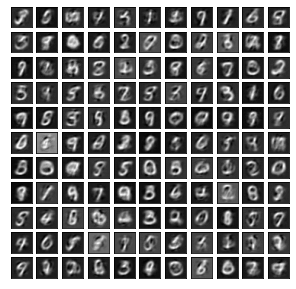

Epoch[20/100],recon_loss:10573.333984, kl_loss:1918.965332


 21%|██        | 21/100 [16:30<1:03:15, 48.04s/it]

Epoch[21/100],recon_loss:11724.897461, kl_loss:1919.978516


 22%|██▏       | 22/100 [17:13<1:00:26, 46.49s/it]

Epoch[22/100],recon_loss:11449.739258, kl_loss:1953.712891


 23%|██▎       | 23/100 [17:52<56:57, 44.39s/it]  

Epoch[23/100],recon_loss:11794.642578, kl_loss:1930.103516


 24%|██▍       | 24/100 [18:38<56:52, 44.90s/it]

Epoch[24/100],recon_loss:10659.846680, kl_loss:1975.131958


 25%|██▌       | 25/100 [19:20<55:03, 44.05s/it]

Epoch[25/100],recon_loss:11106.397461, kl_loss:1949.276733


 26%|██▌       | 26/100 [20:06<55:03, 44.64s/it]

Epoch[26/100],recon_loss:10972.270508, kl_loss:2019.767090


 27%|██▋       | 27/100 [20:49<53:29, 43.97s/it]

Epoch[27/100],recon_loss:11065.298828, kl_loss:1943.981323


 28%|██▊       | 28/100 [21:36<53:57, 44.97s/it]

Epoch[28/100],recon_loss:10628.615234, kl_loss:1914.117188


 29%|██▉       | 29/100 [22:20<52:49, 44.64s/it]

Epoch[29/100],recon_loss:11165.511719, kl_loss:1923.314697


 30%|███       | 30/100 [23:03<51:37, 44.25s/it]

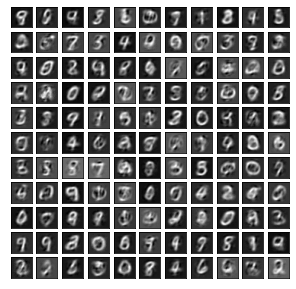

Epoch[30/100],recon_loss:11375.286133, kl_loss:1977.518066


 31%|███       | 31/100 [23:59<54:47, 47.64s/it]

Epoch[31/100],recon_loss:11512.052734, kl_loss:1962.882080


 32%|███▏      | 32/100 [24:48<54:22, 47.97s/it]

Epoch[32/100],recon_loss:10718.968750, kl_loss:1910.827393


 33%|███▎      | 33/100 [25:43<55:59, 50.15s/it]

Epoch[33/100],recon_loss:11704.248047, kl_loss:1948.954468


 34%|███▍      | 34/100 [26:24<52:10, 47.44s/it]

Epoch[34/100],recon_loss:10766.585938, kl_loss:1982.910645


 35%|███▌      | 35/100 [27:13<51:53, 47.90s/it]

Epoch[35/100],recon_loss:11112.652344, kl_loss:1977.850342


 36%|███▌      | 36/100 [27:57<49:59, 46.87s/it]

Epoch[36/100],recon_loss:11004.994141, kl_loss:1953.531616


 37%|███▋      | 37/100 [28:41<48:03, 45.76s/it]

Epoch[37/100],recon_loss:10107.658203, kl_loss:1952.875366


 38%|███▊      | 38/100 [29:19<45:08, 43.69s/it]

Epoch[38/100],recon_loss:10297.666016, kl_loss:1990.406250


 39%|███▉      | 39/100 [30:01<43:46, 43.06s/it]

Epoch[39/100],recon_loss:11160.126953, kl_loss:1988.871216


 40%|████      | 40/100 [30:50<44:54, 44.91s/it]

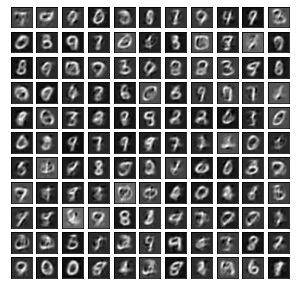

Epoch[40/100],recon_loss:10176.770508, kl_loss:1986.801025


 41%|████      | 41/100 [31:56<50:22, 51.22s/it]

Epoch[41/100],recon_loss:10688.201172, kl_loss:1979.355225


 42%|████▏     | 42/100 [32:32<44:58, 46.53s/it]

Epoch[42/100],recon_loss:10681.769531, kl_loss:1991.835938


 43%|████▎     | 43/100 [33:20<44:33, 46.90s/it]

Epoch[43/100],recon_loss:10403.317383, kl_loss:2023.817383


 44%|████▍     | 44/100 [34:06<43:43, 46.85s/it]

Epoch[44/100],recon_loss:9975.568359, kl_loss:2015.185791


 45%|████▌     | 45/100 [34:54<43:16, 47.20s/it]

Epoch[45/100],recon_loss:11262.457031, kl_loss:2005.593750


 46%|████▌     | 46/100 [35:38<41:25, 46.02s/it]

Epoch[46/100],recon_loss:10764.827148, kl_loss:1986.548828


 47%|████▋     | 47/100 [36:24<40:47, 46.18s/it]

Epoch[47/100],recon_loss:10639.387695, kl_loss:1983.602905


 48%|████▊     | 48/100 [37:05<38:42, 44.66s/it]

Epoch[48/100],recon_loss:11042.701172, kl_loss:2020.252930


 49%|████▉     | 49/100 [37:52<38:26, 45.23s/it]

Epoch[49/100],recon_loss:10608.345703, kl_loss:2086.192871


 50%|█████     | 50/100 [38:41<38:44, 46.50s/it]

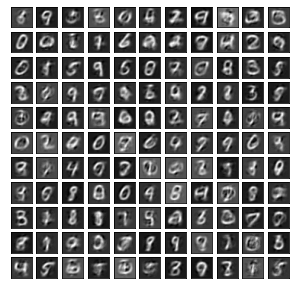

Epoch[50/100],recon_loss:10706.705078, kl_loss:2023.021240


 51%|█████     | 51/100 [39:47<42:43, 52.32s/it]

Epoch[51/100],recon_loss:10703.861328, kl_loss:2016.620605


 52%|█████▏    | 52/100 [40:30<39:37, 49.52s/it]

Epoch[52/100],recon_loss:10237.042969, kl_loss:2055.616699


 53%|█████▎    | 53/100 [41:12<37:00, 47.25s/it]

Epoch[53/100],recon_loss:10143.477539, kl_loss:2001.796143


 54%|█████▍    | 54/100 [42:06<37:46, 49.28s/it]

Epoch[54/100],recon_loss:9948.541016, kl_loss:2040.395020


 55%|█████▌    | 55/100 [42:40<33:36, 44.80s/it]

Epoch[55/100],recon_loss:10321.000000, kl_loss:2022.602173


 56%|█████▌    | 56/100 [43:31<34:07, 46.54s/it]

Epoch[56/100],recon_loss:10467.517578, kl_loss:2019.967163


 57%|█████▋    | 57/100 [44:05<30:39, 42.79s/it]

Epoch[57/100],recon_loss:10430.406250, kl_loss:2056.279785


 58%|█████▊    | 58/100 [44:55<31:22, 44.81s/it]

Epoch[58/100],recon_loss:9904.390625, kl_loss:2023.381836


 59%|█████▉    | 59/100 [45:37<30:08, 44.10s/it]

Epoch[59/100],recon_loss:9880.517578, kl_loss:2073.505859


 60%|██████    | 60/100 [46:23<29:46, 44.67s/it]

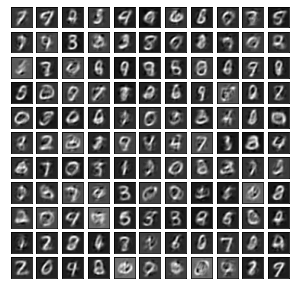

Epoch[60/100],recon_loss:9700.427734, kl_loss:2037.291504


 61%|██████    | 61/100 [47:27<32:46, 50.42s/it]

Epoch[61/100],recon_loss:10765.171875, kl_loss:1999.966797


 62%|██████▏   | 62/100 [48:18<31:58, 50.49s/it]

Epoch[62/100],recon_loss:9824.220703, kl_loss:2003.286621


 63%|██████▎   | 63/100 [48:55<28:39, 46.48s/it]

Epoch[63/100],recon_loss:10209.440430, kl_loss:2041.403809


 64%|██████▍   | 64/100 [49:50<29:31, 49.20s/it]

Epoch[64/100],recon_loss:9590.501953, kl_loss:2041.396851


 65%|██████▌   | 65/100 [50:31<27:09, 46.56s/it]

Epoch[65/100],recon_loss:10239.642578, kl_loss:2016.494263


 66%|██████▌   | 66/100 [51:23<27:24, 48.37s/it]

Epoch[66/100],recon_loss:10122.878906, kl_loss:2013.657593


 67%|██████▋   | 67/100 [52:02<25:06, 45.65s/it]

Epoch[67/100],recon_loss:9474.509766, kl_loss:2026.790039


 68%|██████▊   | 68/100 [52:52<25:00, 46.91s/it]

Epoch[68/100],recon_loss:9901.611328, kl_loss:2041.746460


 69%|██████▉   | 69/100 [53:33<23:20, 45.18s/it]

Epoch[69/100],recon_loss:10530.025391, kl_loss:2048.060059


 70%|███████   | 70/100 [54:24<23:22, 46.74s/it]

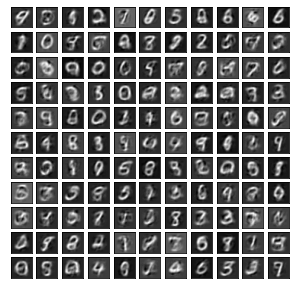

Epoch[70/100],recon_loss:9503.835938, kl_loss:2053.675781


 71%|███████   | 71/100 [55:31<25:32, 52.83s/it]

Epoch[71/100],recon_loss:10162.873047, kl_loss:2032.357422


 72%|███████▏  | 72/100 [56:11<22:53, 49.07s/it]

Epoch[72/100],recon_loss:9342.247070, kl_loss:2088.577148


 73%|███████▎  | 73/100 [57:07<22:56, 50.97s/it]

Epoch[73/100],recon_loss:10086.546875, kl_loss:2044.737061


 74%|███████▍  | 74/100 [57:45<20:25, 47.14s/it]

Epoch[74/100],recon_loss:10273.179688, kl_loss:2032.053833


 75%|███████▌  | 75/100 [58:32<19:40, 47.22s/it]

Epoch[75/100],recon_loss:10586.114258, kl_loss:2024.138550


 76%|███████▌  | 76/100 [59:16<18:29, 46.21s/it]

Epoch[76/100],recon_loss:9044.348633, kl_loss:2051.545410


 77%|███████▋  | 77/100 [59:58<17:10, 44.82s/it]

Epoch[77/100],recon_loss:9679.347656, kl_loss:2089.592773


 78%|███████▊  | 78/100 [1:00:40<16:11, 44.17s/it]

Epoch[78/100],recon_loss:10073.833008, kl_loss:2067.722168


 79%|███████▉  | 79/100 [1:01:20<14:59, 42.84s/it]

Epoch[79/100],recon_loss:9816.633789, kl_loss:2075.276611


 80%|████████  | 80/100 [1:01:49<12:53, 38.68s/it]

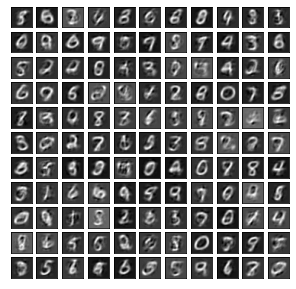

Epoch[80/100],recon_loss:9171.594727, kl_loss:2074.288574


 81%|████████  | 81/100 [1:02:42<13:35, 42.90s/it]

Epoch[81/100],recon_loss:9742.892578, kl_loss:2097.216553


 82%|████████▏ | 82/100 [1:03:14<11:54, 39.71s/it]

Epoch[82/100],recon_loss:9473.462891, kl_loss:2079.112793


 83%|████████▎ | 83/100 [1:04:01<11:50, 41.81s/it]

Epoch[83/100],recon_loss:9533.250000, kl_loss:2068.825928


 84%|████████▍ | 84/100 [1:04:34<10:28, 39.25s/it]

Epoch[84/100],recon_loss:10058.536133, kl_loss:2049.797852


 85%|████████▌ | 85/100 [1:05:07<09:20, 37.38s/it]

Epoch[85/100],recon_loss:9567.813477, kl_loss:2057.721436


 86%|████████▌ | 86/100 [1:05:43<08:35, 36.85s/it]

Epoch[86/100],recon_loss:9822.391602, kl_loss:2019.799316


 87%|████████▋ | 87/100 [1:06:14<07:37, 35.23s/it]

Epoch[87/100],recon_loss:10176.396484, kl_loss:2056.094727


 88%|████████▊ | 88/100 [1:06:59<07:36, 38.02s/it]

Epoch[88/100],recon_loss:9425.185547, kl_loss:2054.571045


 89%|████████▉ | 89/100 [1:07:31<06:39, 36.31s/it]

Epoch[89/100],recon_loss:9393.851562, kl_loss:2027.855835


 90%|█████████ | 90/100 [1:08:10<06:11, 37.19s/it]

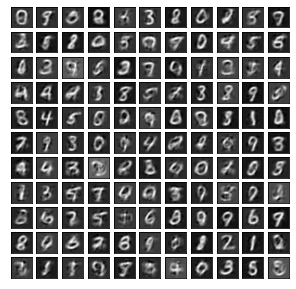

Epoch[90/100],recon_loss:9505.810547, kl_loss:2014.512207


 91%|█████████ | 91/100 [1:08:53<05:48, 38.74s/it]

Epoch[91/100],recon_loss:9787.428711, kl_loss:2105.809082


 92%|█████████▏| 92/100 [1:09:33<05:13, 39.16s/it]

Epoch[92/100],recon_loss:9396.131836, kl_loss:2034.848999


 93%|█████████▎| 93/100 [1:10:03<04:16, 36.65s/it]

Epoch[93/100],recon_loss:10041.782227, kl_loss:2068.854248


 94%|█████████▍| 94/100 [1:10:51<03:58, 39.80s/it]

Epoch[94/100],recon_loss:10289.134766, kl_loss:2072.498779


 95%|█████████▌| 95/100 [1:11:25<03:10, 38.12s/it]

Epoch[95/100],recon_loss:9212.539062, kl_loss:2074.792725


 96%|█████████▌| 96/100 [1:12:05<02:34, 38.69s/it]

Epoch[96/100],recon_loss:9340.878906, kl_loss:2065.974121


 97%|█████████▋| 97/100 [1:12:41<01:53, 37.83s/it]

Epoch[97/100],recon_loss:9624.046875, kl_loss:2051.624756


 98%|█████████▊| 98/100 [1:13:13<01:12, 36.14s/it]

Epoch[98/100],recon_loss:9892.358398, kl_loss:2082.212402


 99%|█████████▉| 99/100 [1:13:52<00:37, 37.15s/it]

Epoch[99/100],recon_loss:9521.162109, kl_loss:2067.436035


100%|██████████| 100/100 [1:14:26<00:00, 44.67s/it]


In [11]:
for epoch in tqdm(range(num_epoch)):
    AE.train()
    
    # epoch_loss = []
    # ========================= Sample and Visualization ====================
    if epoch % 10 == 0:
        VAE.eval()
        # sample z
        z = torch.randn(batch_size, 8).to(device)

        # sample x (i.e. imgs)
        sample = VAE.decoder(z)

        plt.close()
        grid_size, k = int(sample.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(sample[k].data.view(28,28).cpu().numpy(), cmap='gray')
            k += 1
        plt.show()
    # ========================= Training==========================================
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'
        # =============================== IMAGES =================================
        num_img = img.size(0)
        img = img.view(num_img, -1)
        img = img.to(device)
        # =============================== Compute Loss ===========================
        # Get output images, mean, std of encoded space
        reconst_img, mu, log_var = VAE(img)
        
        # l2 (mean squared error) loss.
        recon_loss = torch.sum((img - reconst_img) ** 2)
        
        # Kullback-Leibler divergence between encoded space and Gaussian
        kl_loss = KL_Divergence(mu, log_var)
        
        loss = recon_loss + kl_loss
        
        optimizer.zero_grad() # before back propagation
        loss.backward()
        optimizer.step()
        
        if (i+1)%250 == 0:
                print('Epoch[{}/{}],recon_loss:{:.6f}, kl_loss:{:.6f}'.format(
                    epoch,num_epoch,recon_loss.item(),kl_loss.item()))


# Visualization Phase
## Ex1: Sample image randomly
Generate images by sampling 
$$ z \sim p(z),\quad x \sim p(x|z,\theta) $$ 
PS: Just like we do in training phase per 10 epochs.

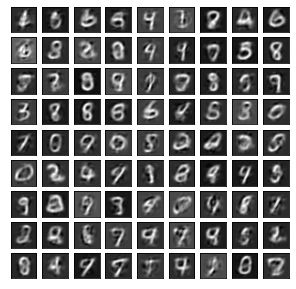

In [12]:
# sample z
z = torch.randn(batch_size, 8).to(device)

# sample x (i.e. imgs)
sample = VAE.decoder(z)

plt.close()
grid_size, k = int(reconst_img.shape[0] ** 0.5), 0 # 10 * 10
fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    ax[i,j].imshow(sample[k].data.view(28,28).cpu().numpy(), cmap='gray')
    k += 1
plt.show()

## Ex2: Sample Interpolated Images
sample two random latent vectors from $p(z)$,
        then sample from their interpolated values

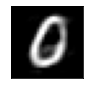

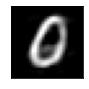

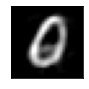

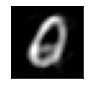

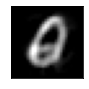

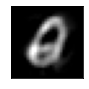

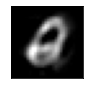

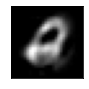

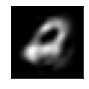

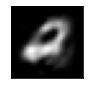

In [13]:
# Sample 2 latent vectors 
z1 = torch.normal(torch.zeros(8), 1) # the first input is the tensor of Mean values
z2 = torch.normal(torch.zeros(8), 1)

# Interpolate within latent vectors

for alpha in np.linspace(0, 1, 10):
    z = (alpha * z1 + (1 - alpha) * z2).to(device)
    sample = VAE.decoder(z)
    img = to_gray_img(sample)
    plt.close()
    fig = plt.figure(figsize=(1,1))
    ax = fig.add_axes([0,0,1,1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img.data.view(28,28).cpu().numpy(), cmap = 'gray')
    plt.show()

## Ex3: Explore the latent space
Sample four random latent vectors from $p(z)$, then sample two of them as the x-axis, the other as y-axis.

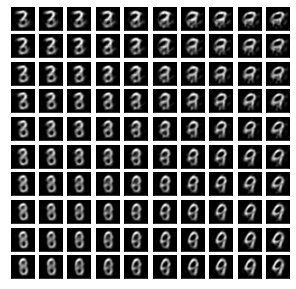

In [14]:
# Sample 2 latent vectors as X-axis 
z1 = torch.normal(torch.zeros(8), 1) # the first input is the tensor of Mean values
z2 = torch.normal(torch.zeros(8), 1)

# Sample 2 latent vectors as Y-axis 
z3 = torch.normal(torch.zeros(8), 1) # the first input is the tensor of Mean values
z4 = torch.normal(torch.zeros(8), 1)




i = 0
j = 0
plt.close()
fig, ax = plt.subplots(10, 10, figsize=(5, 5))

for alpha in np.linspace(0, 1, 10):
    j = 0
    for beta in np.linspace(0, 1, 10):
        z = ((alpha * z1 + (1 - alpha) * z2 + beta * z3 + (1 - beta) * z4)/2).to(device)
        sample = VAE.decoder(z)
        img = to_gray_img(sample)
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].imshow(img.data.view(28,28).cpu().numpy(), cmap='gray')
        j += 1
    i += 1
    
plt.show()